# Running 3 Methods with Simulated Scenarios for Benchmarking

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')
# Initialize the timer
startTime = utils.getTime()

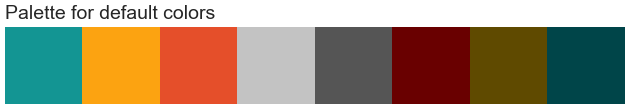

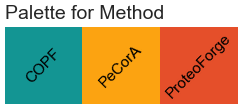

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

method_palette = {
    "COPF": "#139593",
    "PeCorA": "#fca311",
    "ProteoForge": "#e54f2a",
}
method_styles = {
    "COPF": "--",
    "PeCorA": "-.",
    "ProteoForge": ":",
}
method_markers = {
    "COPF": "o",
    "PeCorA": "s",
    "ProteoForge": "^",
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    method_palette, 
    name = "Method",
    save=False
)

In [3]:
notebook_name = "4_IdentificationBench"
data_path = "./data/results/"
output_path = f"./data/results/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

In [13]:
results_data = pd.DataFrame()
pthr = 10**-3
thresholds = list(utils.generate_thresholds(10.0, -15, 1, 0, 1, 0.1))
print(len(thresholds))
# Read and combine the outputs:
for dataID in ["1pep", "2pep", "050pep", "random"]:
    for curMethod in ["COPF", "PeCorA", "ProteoForge"]:
        # Determine the p-value column
        if curMethod == "COPF": 
            pval_col = "proteoform_score_pval"
        else:  
            pval_col = "adj_pval"
        # Read the data
        data = feather.read_dataframe(f"{data_path}{curMethod}_{dataID}_result.feather")
        if curMethod == "ProteoForge":
            data = data[['protein_id', 'peptide_id', 'perturbed_peptide', pval_col]].drop_duplicates()
            
        # Create the metrics data across the thresholds
        metric_data = utils.create_metric_data(
            data,
            thresholds,
            label_col="perturbed_peptide",
            pvalue_col=pval_col,
        )
        metric_data["method"] = curMethod
        metric_data["perturbation"] = dataID
    
        results_data = pd.concat([results_data, metric_data], axis=0, ignore_index=True)


print(f"Data shape: {results_data.shape}")
results_data["perturbation"] = results_data["perturbation"].replace({
    "1pep": "1 Peptide",
    "2pep": "2 Peptides",
    "050pep": "%50 Peptides",
    "random": "Random (1 to %50) Peptides",
})

results_data.head()

25
Data shape: (300, 14)


,TP,FP,TN,FN,TPR,FPR,FDR,MCC,Precision,Recall,F1,threshold,method,perturbation
0,0,0,21247,1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,COPF,1 Peptide
1,0,0,21247,1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,COPF,1 Peptide
2,0,0,21247,1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,COPF,1 Peptide
3,0,0,21247,1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,COPF,1 Peptide
4,0,0,21247,1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,COPF,1 Peptide


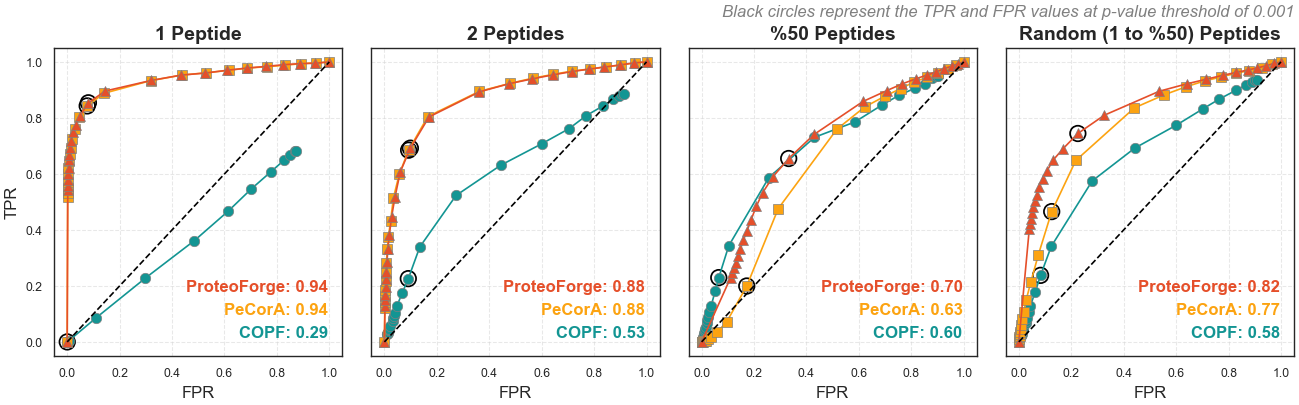

In [14]:
# ROC Curves for different perturbations and methods
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, gridspec_kw={"wspace": 0.1})

for i, pert in enumerate(["1 Peptide", "2 Peptides", "%50 Peptides", "Random (1 to %50) Peptides"]):
    cur_data = results_data[results_data["perturbation"] == pert]

    # Calculate AUC per method from TPR and FPR
    auc_data = cur_data.groupby("method").apply(
        lambda x: np.trapz(x.sort_values("FPR")["TPR"], x.sort_values("FPR")["FPR"])
    )
    # Plot the ROC curve
    sns.lineplot(
        data=cur_data,
        x="FPR",
        y="TPR",
        hue="method",
        style="method",
        palette=method_palette,
        ax=axes[i],
        # Show the points
        markers=method_markers,
        dashes=False,
        markersize=7.5,
        markeredgewidth=0.5,
        markeredgecolor="gray", 
        legend=False,
        rasterized=True 
    )

    # Add AUC values as legend like text
    for j, method in enumerate(auc_data.index):
        auc = auc_data[method]
        # Add color to match the palette
        color = method_palette[method]
        axes[i].text(
            0.95,
            0.05 + j * 0.075,
            f"{method}: {auc:.2f}",
            color=color,
            transform=axes[i].transAxes,
            ha="right",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )
        # Add a large no-facecolor marker to the pthr value for each method
        pthr_data = cur_data[(cur_data["method"] == method) & (cur_data["threshold"] == pthr)]
        axes[i].scatter(
            pthr_data["FPR"],
            pthr_data["TPR"],
            color=color,
            s=125,
            edgecolor="black",
            linewidth=1.25,
            marker="o",
            facecolors="none",
        )

    axes[i].plot([0, 1], [0, 1], color="black", linestyle="--")
    axes[i].set_title(f"{pert}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("FPR", fontsize=12)
    axes[i].set_ylabel("TPR", fontsize=12)
    axes[i].set_xlim(-0.05, 1.05)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Add a text indicating the circle is the p-value threshold under fig.title and above the first subplot
fig.text(
    0.9,
    .97,
    f"Black circles represent the TPR and FPR values at p-value threshold of {pthr}",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)

# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"ROC_curves_perturbations_methods",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

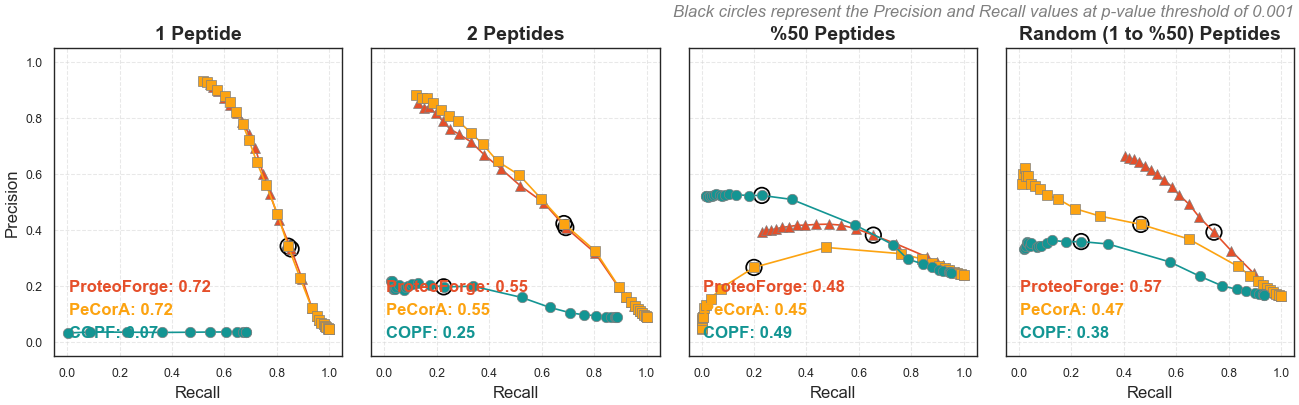

In [15]:
## Precision-Recall Curves for different perturbations and methods
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, gridspec_kw={"wspace": 0.1})

for i, pert in enumerate(["1 Peptide", "2 Peptides", "%50 Peptides", "Random (1 to %50) Peptides"]):
    cur_data = results_data[results_data["perturbation"] == pert].copy()
    # Add a small value to avoid division by zero
    cur_data["Precision"] = cur_data["TP"] / (cur_data["TP"] + cur_data["FP"] + 1e-6)
    cur_data["Recall"] = cur_data["TP"] / (cur_data["TP"] + cur_data["FN"] + 1e-6)
    cur_data["F1"] = 2 * (cur_data["Precision"] * cur_data["Recall"]) / (cur_data["Precision"] + cur_data["Recall"] + 1e-6)
    cur_data = cur_data.sort_values("Recall", ascending=False)
    cur_data = cur_data[~((cur_data["Recall"] == 0) & (cur_data["Precision"] == 0))]

    # Calculate Average F1 score
    f1_data = cur_data.groupby("method")['F1'].max()
    
    # Plot the ROC curve
    sns.lineplot(
        data=cur_data,
        x="Recall",
        y="Precision",
        hue="method",
        style="method",
        palette=method_palette,
        ax=axes[i],
        # Show the points
        markers=method_markers,
        dashes=False,
        markersize=7.5,
        markeredgewidth=0.5,
        markeredgecolor="gray", 
        legend=False,
        rasterized=True 
    )

    # Add AUC values as legend like text
    for j, method in enumerate(f1_data.index):
        auc = f1_data[method]
        # Add color to match the palette
        color = method_palette[method]
        axes[i].text(
            0.05,
            0.05 + j * 0.075,
            f"{method}: {auc:.2f}",
            color=color,
            transform=axes[i].transAxes,
            ha="left",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )
        # Add a large no-facecolor marker to the pthr value for each method
        pthr_data = cur_data[(cur_data["method"] == method) & (cur_data["threshold"] == pthr)]
        axes[i].scatter(
            pthr_data["Recall"],
            pthr_data["Precision"],
            color=color,
            s=125,
            edgecolor="black",
            linewidth=1.25,
            marker="o",
            facecolors="none",
        )

    axes[i].set_title(f"{pert}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Recall", fontsize=12)
    axes[i].set_ylabel("Precision", fontsize=12)
    axes[i].set_xlim(-0.05, 1.05)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Add a text indicating the circle is the p-value threshold under fig.title and above the first subplot
fig.text(
    0.9,
    .97,
    f"Black circles represent the Precision and Recall values at p-value threshold of {pthr}",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)

# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"PR_curves_perturbations_methods",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In [16]:
# Identify the best threshold for each method and perturbation
best_thresholds = results_data.groupby(["method", "perturbation"]).apply(
    lambda x: x.loc[x["F1"].idxmax(), ["threshold", "F1"]]
).reset_index()
best_thresholds.columns = ["method", "perturbation", "threshold", "F1"]
best_thresholds

,method,perturbation,threshold,F1
0,COPF,%50 Peptides,0.1000,0.4876
1,COPF,1 Peptide,0.8000,0.0679
2,COPF,2 Peptides,0.0100,0.2506
3,COPF,Random (1 to %50) Peptides,0.1000,0.3820
4,PeCorA,%50 Peptides,0.1000,0.4455
5,PeCorA,1 Peptide,0.0000,0.7231
6,PeCorA,2 Peptides,0.0000,0.5524
7,PeCorA,Random (1 to %50) Peptides,0.0100,0.4690
8,ProteoForge,%50 Peptides,0.0010,0.4821
9,ProteoForge,1 Peptide,0.0000,0.7224


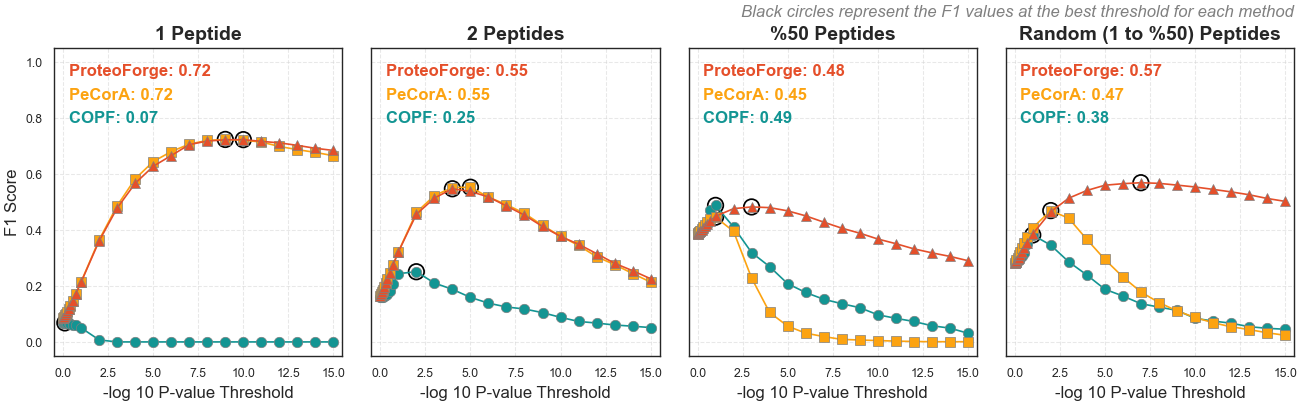

In [17]:
# F1 Score for different perturbations and methods at the best threshold
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, gridspec_kw={"wspace": 0.1})
# Run the loop for each perturbation
for i, pert in enumerate(["1 Peptide", "2 Peptides", "%50 Peptides", "Random (1 to %50) Peptides"]):
    cur_data = results_data[results_data["perturbation"] == pert]
    cur_data["-log10(threshold)"] = -np.log10(cur_data["threshold"])
    sns.lineplot(
        data=cur_data,
        x="-log10(threshold)",
        y="F1",
        hue="method",
        style="method",
        palette=method_palette,
        ax=axes[i],
        markers=method_markers,
        dashes=False,
        markersize=7.5,
        markeredgewidth=0.5,
        markeredgecolor="gray",
        legend=False,
        rasterized=True
    )

    # Add The highest F1 values as legend like text 
    for j, method in enumerate(best_thresholds[best_thresholds["perturbation"] == pert]["method"]):
        f1 = best_thresholds[(best_thresholds["perturbation"] == pert) & (best_thresholds["method"] == method)]["F1"].values[0]
        
        # Add a large no-facecolor marker to the p-value that gives the highest F1 score for each method
        pthr_data = cur_data[
            (cur_data["method"] == method) & 
            (cur_data["threshold"] == best_thresholds[
                (best_thresholds["perturbation"] == pert) & 
                (best_thresholds["method"] == method)
            ]["threshold"].values[0])
        ]
        axes[i].scatter(
            -np.log10(pthr_data["threshold"]),
            pthr_data["F1"],
            color=color,
            s=125,
            edgecolor="black",
            linewidth=1.25,
            marker="o",
            facecolors="none",
        )
        # Add color to match the palette
        color = method_palette[method]
        axes[i].text(
            0.05,
            0.75 + j * 0.075,
            f"{method}: {f1:.2f}",
            color=color,
            transform=axes[i].transAxes,
            ha="left",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )

    axes[i].set_title(f"{pert}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("-log 10 P-value Threshold", fontsize=12)
    axes[i].set_ylabel("F1 Score", fontsize=12)
    axes[i].set_xlim(-0.5, 15.5)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

fig.text(
    0.9,
    .97,
    f"Black circles represent the F1 values at the best threshold for each method",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)
# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"F1_scores_perturbations_methods",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In [18]:
best_thresholds = results_data.groupby(["method", "perturbation"]).apply(
    lambda x: x.loc[x["MCC"].idxmax(), ["threshold", "MCC"]]
).reset_index()
best_thresholds.columns = ["method", "perturbation", "threshold", "MCC"]
best_thresholds

,method,perturbation,threshold,MCC
0,COPF,%50 Peptides,0.1000,0.2981
1,COPF,1 Peptide,0.0000,0.0000
2,COPF,2 Peptides,0.0100,0.1620
3,COPF,Random (1 to %50) Peptides,0.1000,0.2322
4,PeCorA,%50 Peptides,0.1000,0.2100
5,PeCorA,1 Peptide,0.0000,0.7193
6,PeCorA,2 Peptides,0.0000,0.5133
7,PeCorA,Random (1 to %50) Peptides,0.0100,0.3515
8,ProteoForge,%50 Peptides,0.0001,0.2842
9,ProteoForge,1 Peptide,0.0000,0.7160


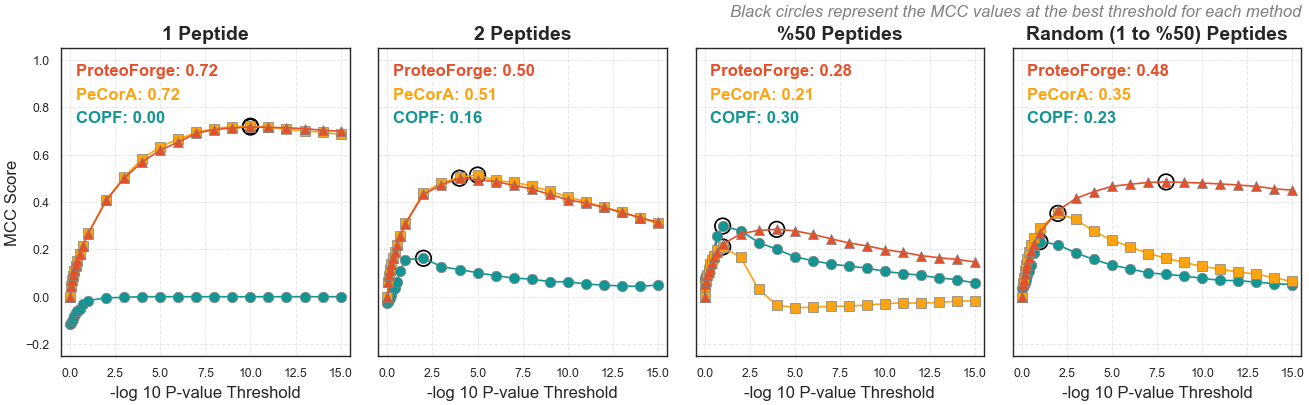

In [19]:
# MCC Score for different perturbations and methods at the best threshold
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, gridspec_kw={"wspace": 0.1})
# Run the loop for each perturbation
for i, pert in enumerate(["1 Peptide", "2 Peptides", "%50 Peptides", "Random (1 to %50) Peptides"]):
    cur_data = results_data[results_data["perturbation"] == pert].copy()
    cur_data["-log10(threshold)"] = -np.log10(cur_data["threshold"])
    sns.lineplot(
        data=cur_data,
        x="-log10(threshold)",
        y="MCC",
        hue="method",
        style="method",
        palette=method_palette,
        ax=axes[i],
        markers=method_markers,
        dashes=False,
        markersize=7.5,
        markeredgewidth=0.5,
        markeredgecolor="gray",
        legend=False,
        rasterized=True
    )

    # Add The highest MCC values as legend like text 
    for j, method in enumerate(best_thresholds[best_thresholds["perturbation"] == pert]["method"]):
        mcc = best_thresholds[(best_thresholds["perturbation"] == pert) & (best_thresholds["method"] == method)]["MCC"].values[0]
        
        # Add a large no-facecolor marker to the p-value that gives the highest MCC score for each method
        pthr_data = cur_data[
            (cur_data["method"] == method) & 
            (cur_data["threshold"] == best_thresholds[
                (best_thresholds["perturbation"] == pert) & 
                (best_thresholds["method"] == method)
            ]["threshold"].values[0])
        ]
        axes[i].scatter(
            -np.log10(pthr_data["threshold"]),
            pthr_data["MCC"],
            color=color,
            s=125,
            edgecolor="black",
            linewidth=1.25,
            marker="o",
            facecolors="none",
        )
        # Add color to match the palette
        color = method_palette[method]
        axes[i].text(
            0.05,
            0.75 + j * 0.075,
            f"{method}: {mcc:.2f}",
            color=color,
            transform=axes[i].transAxes,
            ha="left",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )

    axes[i].set_title(f"{pert}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("-log 10 P-value Threshold", fontsize=12)
    axes[i].set_ylabel("MCC Score", fontsize=12)
    axes[i].set_xlim(-0.5, 15.5)
    axes[i].set_ylim(-0.25, 1.05)
    axes[i].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
    
fig.text(
    0.9,
    .97,
    f"Black circles represent the MCC values at the best threshold for each method",
    ha="right",
    va="center",
    fontsize=12,
    fontstyle="italic",
    color="gray",
)
# Finalize the plot
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"MCC_scores_perturbations_methods",
        filepath = figure_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )